# Hasse Search Space Estimation

## Load Data

In [1]:
import json
import numpy as np
from os import listdir
from pprint import pprint
from statistics import mean, stdev
from typing import List, Dict

In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm
from tqdm import tqdm

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load data

def get_file_paths(dir_path: str = "results") -> List[str]:
    file_names = listdir(dir_path)
    file_names = [file_name for file_name in file_names if file_name.endswith(".json")]

    file_paths = [
        f"{dir_path}/{file_name}"  for file_name in file_names
    ]
    return file_paths


def load_data(file_path: str) -> Dict:
    with open(file_path, "r") as data_file:
        return json.load(data_file)

experiment_paths = get_file_paths()
experiments = [
    load_data(file_path) for file_path in experiment_paths
]

print(f"Experiment count: {len(experiments)}")
print(experiments[0])

Experiment count: 7
{'meta': {'start': '2025-11-18 04:40:51.679549', 'end': '2025-11-18 05:55:44.413689'}, 'config': {'gate_set': '[H, S, T, CX]', 'gate_count': 10, 'qubit_num': 4, 'sample_num': 500000, 'seed_num': 30}, 'results': {'simulation_times': [46.398199, 46.245061, 46.182761, 46.887043, 46.073721, 46.010228, 46.057709, 46.169144, 46.242098, 46.281225, 46.013078, 46.070606, 45.982048, 45.974078, 46.28006, 46.670651, 46.311552, 46.231491, 46.103086, 46.252418, 46.394454, 46.509098, 46.258957, 46.321757, 46.254032, 46.284995, 46.466241, 46.178927, 46.206987, 46.6258], 'mean_simulation_time': 46.2645835, 'hasse_duplicate_counts': [11, 6, 13, 9, 10, 7, 11, 9, 8, 9, 11, 14, 12, 11, 9, 12, 19, 8, 11, 14, 8, 7, 14, 4, 7, 9, 14, 17, 16, 8], 'mean_hasse_duplicate_count': 10.6, 'hasse_encoding_times': [80.670273, 80.531476, 80.860211, 80.81519, 80.392297, 80.182943, 80.717139, 80.54434, 80.708374, 80.770761, 80.730313, 80.246135, 80.772657, 80.480279, 80.931415, 80.472027, 80.626828, 80.

In [5]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

In [6]:
# Filter experiments

def filter_experiments(experiments: List[Dict], target_qubit_nums: List[int] = None, target_gate_counts: List[int] = None, sort_by: str = "qubit_num") -> List:
    assert target_qubit_nums is not None or target_gate_counts is not None

    filtered_experiments = []
    for experiment in experiments:

        if target_qubit_nums is None:
            if experiment["config"]["gate_count"] in target_gate_counts:
                filtered_experiments.append(experiment)
        elif target_gate_counts is None:
            if experiment["config"]["qubit_num"] in target_qubit_nums:
                filtered_experiments.append(experiment)
        elif experiment["config"]["gate_count"] in target_gate_counts and experiment["config"]["qubit_num"] in target_qubit_nums: 
            filtered_experiments.append(experiment)

    filtered_experiments.sort(key=lambda item: item["config"][sort_by])
    return filtered_experiments

## Compute Search Space Size

In [7]:
def calculate_list_search_space_size(qubit_num: int, gate_count: int) -> int:
    # assuming Clifford+T gate set 

    return (qubit_num * (qubit_num - 1) + 3 * qubit_num) ** gate_count

In [8]:
# Calculate search space size

def calculate_expected_duplicates(size: int, sample_num: int) -> int:
    expected_duplicates = sample_num - size + size * (1 - 1/size) ** sample_num
    return expected_duplicates


def estimate_search_space_size(sample_num: int, actual_duplicates: int, lower_bound: int, upper_bound: int) -> int:
    if actual_duplicates == 0:
        return upper_bound

    # Expected number of duplicates decreases monotonically as search space increases

    search_range = (lower_bound, upper_bound)
    search_post_count = 3

    while True:

        # cut search interval into bins and evaluate
        search_posts = [
            i * (search_range[1] - search_range[0]) / (search_post_count - 1) + search_range[0] for i in range(search_post_count)
        ]
        search_posts = [int(search_post) for search_post in search_posts]

        smallest_delta = np.inf
        best_i = -1

        for search_post_i, search_post in enumerate(search_posts):
            estimated_duplicates = calculate_expected_duplicates(
                search_post, sample_num)
            delta = abs(estimated_duplicates - actual_duplicates)

            if delta < smallest_delta:
                smallest_delta = delta
                best_i = search_post_i

        if smallest_delta <= 1:
            return search_posts[best_i]

        try:
            if calculate_expected_duplicates(search_posts[best_i], sample_num) > actual_duplicates:
                search_range = (search_posts[best_i], search_posts[best_i + 1])
            else:
                search_range = (search_posts[best_i - 1], search_posts[best_i])
        except IndexError:  # Case: border of search posts is closest to solution.
            return search_posts[best_i]

        if (search_range[1] - search_range[0]) / (search_post_count - 1) <= 1:
            return search_posts[best_i]


{'gate_set': '[H, S, T, CX]', 'gate_count': 10, 'qubit_num': 3, 'sample_num': 500000, 'seed_num': 30}
[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Estimates: [2883251953125, 2883251953125, 2883251953125, 2883251953125, 90101623536, 90101623536, 2883251953125, 2883251953125, 2883251953125, 90101623536, 90101623536, 2883251953125, 2883251953125, 2883251953125, 2883251953125, 90101623536, 90101623536, 2883251953125, 2883251953125, 2883251953125, 2883251953125, 2883251953125, 2883251953125, 2883251953125, 90101623536, 2883251953125, 2883251953125, 2883251953125, 90101623536, 2883251953125]
Mean estimate: 101364326477
Actual: 576650390625

{'gate_set': '[H, S, T, CX]', 'gate_count': 10, 'qubit_num': 4, 'sample_num': 500000, 'seed_num': 30}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Estimates: [317016904826880, 317016904826880, 317016904826880, 317016904826880, 317016904826880, 317016904826880, 317

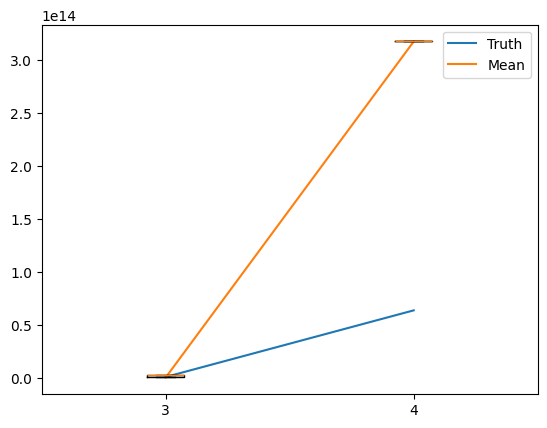

In [20]:
filtered_experiments = filter_experiments(experiments, target_gate_counts=[10])

qubit_nums = []
total_estimates: List[List] = []
total_actual_values: List = []
total_mean_estimates: List = []

for experiment in filtered_experiments:
    print("")
    print(experiment["config"])
    print(experiment["results"]["list_duplicate_counts"])

    qubit_nums.append(experiment["config"]["qubit_num"])

    actual = calculate_list_search_space_size(
        experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
    total_actual_values.append(actual)

    estimates = [
        estimate_search_space_size(
            experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual * 5)
            for duplicate_count in experiment["results"]["list_duplicate_counts"]
    ]
    
    total_estimates.append(estimates)
    
    mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_list_duplicate_count"], lower_bound=1, upper_bound=actual * 5)
    total_mean_estimates.append(mean_estimate)

    print(f"Estimates: {estimates}")
    print(f"Mean estimate: {mean_estimate}")
    print(f"Actual: {actual}")



fig, ax = plt.subplots()
ax.plot(qubit_nums, total_actual_values, label="Truth")
ax.plot(qubit_nums, total_mean_estimates, label="Mean")
ax.boxplot(total_estimates, positions=qubit_nums,
                showfliers=False,
                )

plt.legend()
plt.show()


## Search Space Hasse vs. List

In [10]:
gate_counts = [
    experiment["config"]["gate_count"] for experiment in experiments
]
gate_counts = list(set(gate_counts))
gate_counts.sort()

qubit_nums = [
    experiment["config"]["qubit_num"] for experiment in experiments
]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

100%|██████████| 2/2 [00:00<00:00, 1057.70it/s]


Search space sizes for 5 gates.
Qubit nums:  [3, 4]
List search space:  [759375, 7962624]
Hasse search space:  [100602, 465619]
Ratio:  [0.1325, 0.0585]


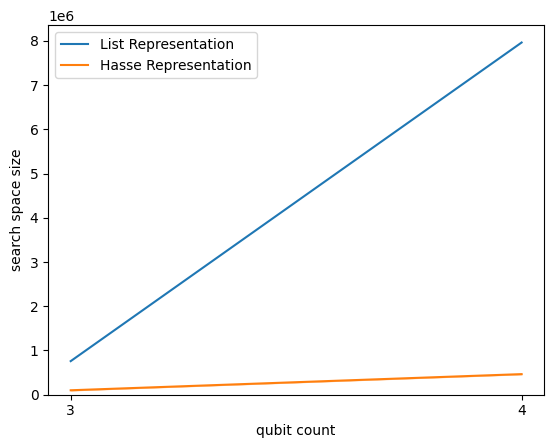

100%|██████████| 2/2 [00:00<00:00, 606.60it/s]


Search space sizes for 10 gates.
Qubit nums:  [3, 4]
List search space:  [576650390625, 63403380965376]
Hasse search space:  [432487420103, 52366308461568]
Ratio:  [0.75, 0.8259]


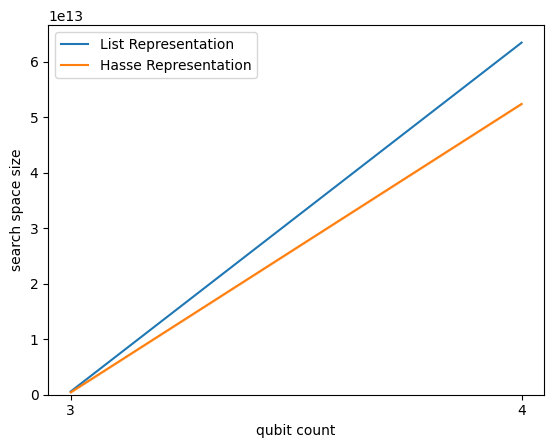

100%|██████████| 2/2 [00:00<00:00, 2906.66it/s]


Search space sizes for 15 gates.
Qubit nums:  [3, 4]
List search space:  [437893890380859375, 504857282956046106624]
Hasse search space:  [656840835571289088, 1514571848868138319872]
Ratio:  [1.5, 3.0]


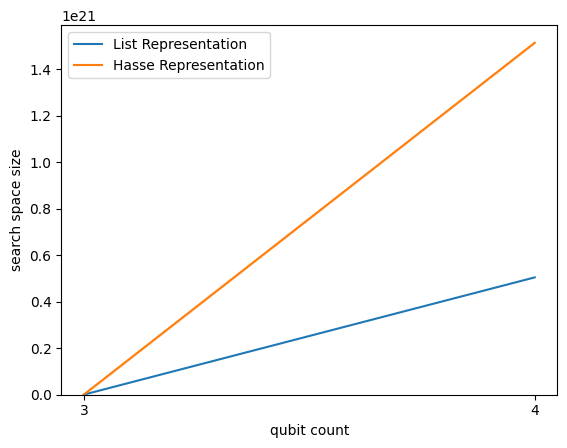

100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]



Search space sizes for 20 gates.
Qubit nums:  [3]
List search space:  [332525673007965087890625]
Hasse search space:  [997577019023895263671875]
Ratio:  [3.0]


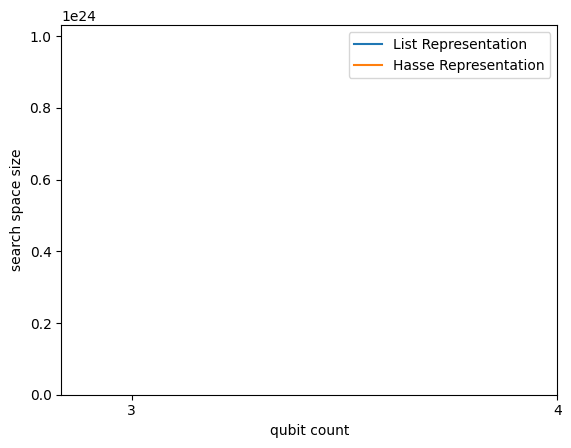

In [11]:
# accross gate counts

for gate_count in gate_counts:

    # if gate_count > 10:
    #     break

    filtered_experiments = filter_experiments(
        experiments, target_gate_counts=[gate_count])

    encountered_qubit_nums = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in tqdm(filtered_experiments):
        encountered_qubit_nums.append(experiment["config"]["qubit_num"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=3 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=3 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {gate_count} gates.")
    print("Qubit nums: ", encountered_qubit_nums)
    print("List search space: ", total_list_values)
    print("Hasse search space: ", total_hasse_estimates)
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_qubit_nums, total_list_values,
            label="List Representation")

    ax.plot(encountered_qubit_nums, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("qubit count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(qubit_nums)

    plt.legend()
    plt.savefig(f"results/fig_space_{gate_count}g_varying_q.png", bbox_inches='tight')
    plt.show()


Search space sizes for 3 qubits.
Gate counts:  [5, 10, 15, 20]
List search space:  [759375, 576650390625, 437893890380859375, 332525673007965087890625]
Hasse search space:  [100603, 143599379108, 437893890380859392, 665051346015930175781250]
Ratio:  [0.1325, 0.249, 1.0, 2.0]


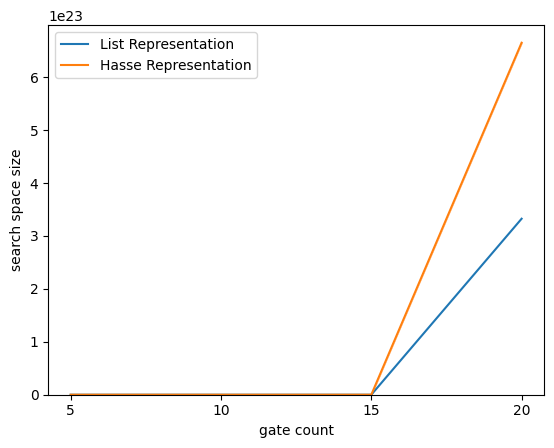


Search space sizes for 4 qubits.
Gate counts:  [5, 10, 15]
List search space:  [7962624, 63403380965376, 504857282956046106624]
Hasse search space:  [465618, 63879370702848, 1009714565912092213248]
Ratio:  [0.0585, 1.0075, 2.0]


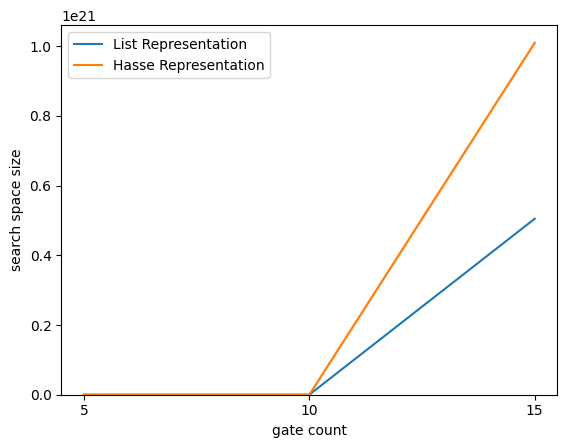

In [12]:
# accross qubit nums

for qubit_num in qubit_nums:

    # filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
    #                                           qubit_num], target_gate_counts=[5, 10], sort_by="gate_count")
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
                                              qubit_num], sort_by="gate_count")

    encountered_gate_counts = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in filtered_experiments:
        encountered_gate_counts.append(experiment["config"]["gate_count"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=2 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=2 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {qubit_num} qubits.")
    print("Gate counts: ", encountered_gate_counts)
    print("List search space: ", total_list_values)
    print("Hasse search space: ", total_hasse_estimates)
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_gate_counts, total_list_values,
            label="List Representation")

    ax.plot(encountered_gate_counts, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_gate_counts, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("gate count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(encountered_gate_counts)

    plt.legend()

    plt.savefig(
        f"results/fig_space_{qubit_num}q_varying_g.png", bbox_inches='tight')
    plt.show()